In [211]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import random
import os
import time
import math

DEVICE = torch.device('cuda')

In [212]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)


def get_mnist_dl(batch_size_train=256, batch_size_eval=256, device=torch.device('cpu')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [213]:

class MLP_Net(nn.Module):

  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 1024)
    self.Relu1 = nn.ReLU()
    self.fc2 = nn.Linear(1024, 1024)
    self.Relu2 = nn.ReLU()
    self.fc3 = nn.Linear(1024, 1024)
    self.Relu3 = nn.ReLU()
    self.fc5 = nn.Linear(1024, num_classes)
    #self.softmax = nn.Softmax()


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.flatten(x)
    x = self.Relu1(self.fc1(x))
    x = self.Relu2(self.fc2(x))
    x = self.Relu3(self.fc3(x))
    x = self.fc5(x)
    
    return x


In [214]:
class CNN_Net(nn.Module):
    def __init__(self, num_classes=10) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 26, kernel_size=5, stride=1, padding = 0)
        self.maxpooling1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(26, 52, kernel_size=3, stride=1, padding = 0)

        self.conv3 = nn.Conv2d(52, 10, kernel_size=1, stride=1, padding=0)
        self.maxpooling3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_1 = nn.Linear(5*5*10, 1000)
        self.fc_2 = nn.Linear(1000, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.maxpooling1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.maxpooling3(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

In [215]:
def print_stats(stats):

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3), dpi=110)
  ax1.grid()
  ax2.grid()

  ax1.set_title("ERM loss")
  ax2.set_title("Valid Acc")
  
  ax1.set_xlabel("iterations")
  ax2.set_xlabel("iterations")

  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  ax1.plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  ax2.plot(itrs, acc)

  ax1.set_ylim(0.0, 15.05)
  ax2.set_ylim(0.0, 1.05)


@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()


def run_experiment(model, opt, train_dl, valid_dl, test_dl, use_forward_grad=False, num_forward_grad=1, max_epochs=20):

  itr = -1
  stats = {'train-loss': [], 'valid-acc':[]}
  time_list = []

  for epoch in range(max_epochs):
    for x, y in train_dl:
        itr += 1
        layer_inputs = {}
        def hook(mod, input):
            layer_inputs[mod] = input[0]
        for module in model.modules():
            module.register_forward_pre_hook(hook)
        opt.zero_grad()
        #start_2 = time.clock()
        #print(torch.cuda.memory_allocated()/1024/1024)
        loss = F.cross_entropy(model(x), y)
        #print(torch.cuda.memory_allocated()/1024/1024)
        loss.backward()
        #print(torch.cuda.memory_allocated()/1024/1024)
        
        if use_forward_grad:
          with torch.no_grad():
            #v_list = []
            #da = torch.zeros(num_forward_grad, 1).to(DEVICE)
            for p in model.parameters():
              g = p.grad.view(-1)
              v = torch.randn(num_forward_grad, len(g), device=DEVICE)
              #v = v/v.norm()
              #da  = da + (v @ g).view(num_forward_grad,1)
              #v_list.append(v)
              g = ((v @ g).view(num_forward_grad,1) * v).mean(dim=0)
              #g = g*len(p.grad.view(-1))
              p.grad = g.view(p.grad.shape)
        '''
        if use_forward_grad:
          with torch.no_grad():
            #v_list = []
            da = torch.zeros(num_forward_grad, 1).to(DEVICE)
            for p in model.parameters():
              g = p.grad.view(-1)
              v = torch.randn(num_forward_grad, len(g), device=DEVICE)
              source = torch.randn(len(g), device=DEVICE)
              gap = math.floor(len(g)/num_forward_grad)
              for i in range(num_forward_grad):
                if i<num_forward_grad-1:
                  v[i] = F.pad(source[i*gap:(i+1)*gap], pad = (i*gap, len(g)-(i+1)*gap))
                else:
                  v[i] = F.pad(source[i*gap:], pad = (i*gap, 0))
              da  = da + (v @ g).view(num_forward_grad,1)
              #v_list.append(v)
              g = ((v @ g).view(num_forward_grad,1) * v).mean(dim=0)
              p.grad = g.view(p.grad.shape)
 
        
        if use_forward_grad:
          with torch.no_grad():
            for name, module in model.named_modules():
              if isinstance(module, torch.nn.Linear):
                grad_w = module.weight.grad
                approx = using_inputs_project(grad_w, layer_inputs[module])
                module.weight.grad = approx
                grad_b = module.bias.grad.view(-1)
                v = torch.randn(num_forward_grad, len(grad_b), device=DEVICE)
                grad_b = ((v @ grad_b).view(num_forward_grad,1) * v).mean(dim=0)
                module.bias.grad = grad_b.view(module.bias.grad.shape)
        '''
        
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.25, norm_type=2)
        opt.step()
        #print(torch.cuda.memory_allocated()/1024/1024)

        stats['train-loss'].append((itr, loss.item()))

        if itr % 20 == 0:
          valid_acc = get_acc(model, valid_dl)
          stats['valid-acc'].append((itr, valid_acc))
          s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
          print(s)
          time_list = []

  test_acc = get_acc(model, test_dl)
  print(f"[test] acc:{test_acc:.3f}")
  return stats


In [216]:
def using_inputs_project(grad, input):
    noise = torch.randn(grad.shape[0], device=DEVICE)
    '''
    inpt = torch.mean(input, dim = 0).view(-1)[None, :]

    entry_from_batch = torch.randint(low=0, high=len(input), size=[])
    inpt = input[entry_from_batch].view(-1)[None, :]
    inpt /= inpt.norm()
    '''
    q,r = torch.qr(input.T)
    entry_from_batch = torch.randint(low=0, high=len(input), size=[])
    inpt = q.T[entry_from_batch].view(-1)[None, :]
    expanded_noise = noise[:, None] * inpt
    return expanded_noise * torch.sum(expanded_noise * grad)

0:0 [train] loss:23.805, [valid] acc:0.074
0:20 [train] loss:13.256, [valid] acc:0.093
0:40 [train] loss:9.974, [valid] acc:0.111
0:60 [train] loss:8.470, [valid] acc:0.129
0:80 [train] loss:7.026, [valid] acc:0.160
0:100 [train] loss:7.038, [valid] acc:0.190
0:120 [train] loss:5.646, [valid] acc:0.218
0:140 [train] loss:4.761, [valid] acc:0.246
0:160 [train] loss:5.482, [valid] acc:0.270
0:180 [train] loss:4.811, [valid] acc:0.299
0:200 [train] loss:4.344, [valid] acc:0.323
1:220 [train] loss:4.718, [valid] acc:0.344
1:240 [train] loss:4.319, [valid] acc:0.371
1:260 [train] loss:4.148, [valid] acc:0.387
1:280 [train] loss:3.960, [valid] acc:0.412
1:300 [train] loss:3.146, [valid] acc:0.427
1:320 [train] loss:3.522, [valid] acc:0.443
1:340 [train] loss:2.838, [valid] acc:0.462
1:360 [train] loss:2.706, [valid] acc:0.479
1:380 [train] loss:3.013, [valid] acc:0.490
1:400 [train] loss:2.577, [valid] acc:0.503
1:420 [train] loss:2.733, [valid] acc:0.513
2:440 [train] loss:2.521, [valid] ac

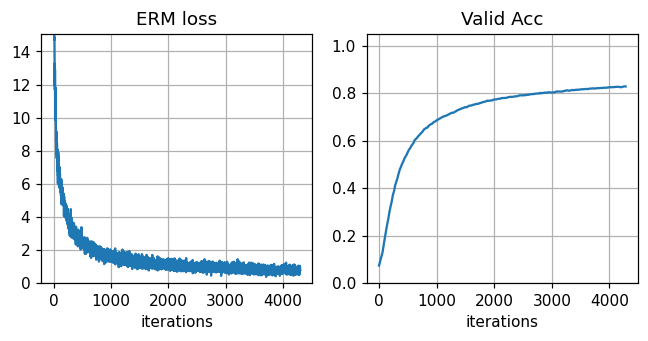

In [217]:
train_dl, valid_dl, test_dl = get_mnist_dl(device=DEVICE)

model = MLP_Net().to(DEVICE)

for p in model.parameters():
    g = p.view(-1)
    v = torch.normal(mean = torch.full((1, len(g)), 0.), std = torch.full((1, len(g)), 0.1)).to(DEVICE)
    p.data = v.view(p.shape)

opt = torch.optim.SGD(model.parameters(), lr=1e-4)


stats = run_experiment(model, opt, train_dl, valid_dl, test_dl, use_forward_grad=False, num_forward_grad = 1, max_epochs=20)

print_stats(stats)

In [218]:
res = 0
for i in range(1000):
    a = torch.randn(2000)
    res += ((a[3]*a[3])/(a.norm()**2))
print(res/1000)
    

tensor(0.0005)


In [219]:
a = torch.randn(1, 2000)
a = a/a.norm()
a.norm()

tensor(1.0000)